In [141]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

Attribute Information:

InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.

Description: Product (item) name. Nominal.

Quantity: The quantities of each product (item) per transaction. Numeric.

InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated. (From Dec 1 2010 - Dec 9 2011)

UnitPrice: Unit price. Numeric, Product price per unit in sterling.

CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

Country: Country name. Nominal, the name of the country where each customer resides.

In [2]:
# Establish connection with internal db
con = sqlite3.connect('UCI.db')
cursor = con.cursor()

In [3]:
# Drop tables that already exist by running the following commands
cursor.executescript("DROP TABLE IF EXISTS transactions")

In [4]:
# read csv files
transactions_df = pd.read_csv("UCI_online/data.csv")

In [5]:
# import data to sqlite3
transactions_df.to_sql('transactions', con)

In [6]:
# verify that all data are loaded to the database
transactions = pd.read_sql('SELECT * FROM transactions', con)
transactions.head(n=10)

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom
5,5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/10 8:26,7.65,17850.0,United Kingdom
6,6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/10 8:26,4.25,17850.0,United Kingdom
7,7,536366,22633,HAND WARMER UNION JACK,6,12/1/10 8:28,1.85,17850.0,United Kingdom
8,8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/10 8:28,1.85,17850.0,United Kingdom
9,9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/10 8:34,1.69,13047.0,United Kingdom


In [10]:
# Aggregate by invoice number
sql1 = """
SELECT * FROM transactions
GROUP BY InvoiceNo;
"""
sql1_df = pd.read_sql(sql1, con)
sql1_df.head(n=10)

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,7,536366,22633,HAND WARMER UNION JACK,6,12/1/10 8:28,1.85,17850.0,United Kingdom
2,9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/10 8:34,1.69,13047.0,United Kingdom
3,21,536368,22960,JAM MAKING SET WITH JARS,6,12/1/10 8:34,4.25,13047.0,United Kingdom
4,25,536369,21756,BATH BUILDING BLOCK WORD,3,12/1/10 8:35,5.95,13047.0,United Kingdom
5,26,536370,22728,ALARM CLOCK BAKELIKE PINK,24,12/1/10 8:45,3.75,12583.0,France
6,46,536371,22086,PAPER CHAIN KIT 50'S CHRISTMAS,80,12/1/10 9:00,2.55,13748.0,United Kingdom
7,47,536372,22632,HAND WARMER RED POLKA DOT,6,12/1/10 9:01,1.85,17850.0,United Kingdom
8,49,536373,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 9:02,2.55,17850.0,United Kingdom
9,65,536374,21258,VICTORIAN SEWING BOX LARGE,32,12/1/10 9:09,10.95,15100.0,United Kingdom


In [38]:
# Aggregate by customerID
# Requires: customer ID not null; total_value positive; at least 5 transactions
sql2 = """
SELECT CustomerID, SUM(Quantity*UnitPrice) AS total_value, 
SUM(Quantity*UnitPrice)/COUNT(*) AS average, COUNT(*) AS times
FROM transactions
WHERE CustomerID IS NOT NULL
GROUP BY CustomerID 
HAVING COUNT(*) > 4 AND total_value > 0
ORDER BY COUNT(*) DESC
"""
sql2_df = pd.read_sql(sql2, con)
sql2_df.head(n=10)

,CustomerID,total_value,average,times
0,17841.0,40340.78,5.053336,7983
1,14911.0,132572.62,22.458516,5903
2,14096.0,57120.91,11.139023,5128
3,12748.0,29072.10,6.262839,4642
4,14606.0,11713.85,4.210586,2782
5,15311.0,59419.34,23.853609,2491
6,14646.0,279489.02,134.047492,2085
7,13089.0,57385.88,30.902466,1857
8,13263.0,7454.07,4.444884,1677
9,14298.0,50862.44,31.013683,1640


In [47]:
# the distribution of # of transactions per customer
customer_times_vector = np.array(sql2_df['times'])
count_vector = [np.sum(customer_times_vector==i) for i in range(8000)]

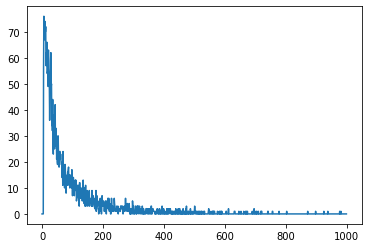

In [45]:
# customers purchasing < 1000 times
plt.plot(range(1000), count_vector[:1000])

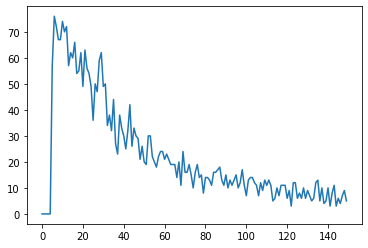

In [46]:
# customers purchasing < 150 times
plt.plot(range(150), count_vector[:150])

## Data preprocessing

In [103]:
# Transactions data in 2010 & 2011 Jan-Sept as training data
# %m/%d/%y
train_df = transactions_df[transactions_df['InvoiceDate'].str.match('^(\d+/\d+/10|[1-9]/\d+/11)')==True]
# train_df

In [104]:
# Rest as test data
test_df = transactions_df.merge(train_df, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']
# test_df

In [105]:
# Check data types. 
train_df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [123]:
# We are concerned with InvoiceDate want to transform it into a datetime object.
train_df['InvoiceDate'] = pd.to_datetime(train_df['InvoiceDate'], format='%m/%d/%y %H:%M').dt.date
test_df['InvoiceDate'] = pd.to_datetime(test_df['InvoiceDate'], format='%m/%d/%y %H:%M').dt.date

/Users/daiyangli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [134]:
# train_df

In [128]:
# Import the training data into db
train_df.to_sql("train", con=con, if_exists="replace")

In [129]:
# Show db table schema. 
sql3_df = pd.read_sql("PRAGMA table_info('train')", con)
sql3_df

,cid,name,type,notnull,dflt_value,pk
0,0,index,INTEGER,0,None,0
1,1,InvoiceNo,TEXT,0,None,0
2,2,StockCode,TEXT,0,None,0
3,3,Description,TEXT,0,None,0
4,4,Quantity,INTEGER,0,None,0
5,5,InvoiceDate,DATE,0,None,0
6,6,UnitPrice,REAL,0,None,0
7,7,CustomerID,REAL,0,None,0
8,8,Country,TEXT,0,None,0


In [133]:
# Aggregate by customers, with columns of info that we need.
# Requires: customer ID not null; total_value positive; at least 3 purchasing date
sql4 = """
SELECT CustomerID, SUM(Quantity*UnitPrice) AS total_value, 
MAX(InvoiceDate) AS latest, MIN(InvoiceDate) AS first, 
SUM(Quantity*UnitPrice)/COUNT(DISTINCT InvoiceDate) AS average, COUNT(DISTINCT InvoiceDate) AS times
FROM train
WHERE CustomerID IS NOT NULL
GROUP BY CustomerID 
HAVING COUNT(DISTINCT InvoiceDate) > 2 AND total_value > 0
ORDER BY COUNT(DISTINCT InvoiceDate) DESC
"""
sql4_df = pd.read_sql(sql4, con)
sql4_df

,CustomerID,total_value,latest,first,average,times
0,14911.0,85626.75,2011-09-30,2010-12-01,815.492857,105
1,17841.0,25595.39,2011-09-28,2010-12-01,304.707024,84
2,12748.0,17320.42,2011-09-30,2010-12-01,213.832346,81
3,14606.0,9565.12,2011-09-28,2010-12-01,132.848889,72
4,15311.0,47342.51,2011-09-27,2010-12-01,676.321571,70
5,13089.0,44933.07,2011-09-30,2010-12-05,660.780441,68
6,16422.0,29786.81,2011-09-27,2010-12-05,504.861186,59
7,12971.0,8394.15,2011-09-27,2010-12-02,152.620909,55
8,14527.0,5302.52,2011-09-29,2010-12-01,108.214694,49
9,13408.0,19957.22,2011-09-25,2010-12-01,475.171905,42


In [142]:
# Add recency attribute (last purchase - first purchase)
sql4_df[['latest','first']] = sql4_df[['latest','first']].apply(pd.to_datetime) #conversion required
sql4_df['recency'] = (sql4_df['latest'] - sql4_df['first']).dt.days
sql4_df['age'] = (datetime.datetime(2011,10,1)-sql4_df['first']).dt.days

In [143]:
sql4_df

,CustomerID,total_value,latest,first,average,times,recency,age
0,14911.0,85626.75,2011-09-30,2010-12-01,815.492857,105,303,304
1,17841.0,25595.39,2011-09-28,2010-12-01,304.707024,84,301,304
2,12748.0,17320.42,2011-09-30,2010-12-01,213.832346,81,303,304
3,14606.0,9565.12,2011-09-28,2010-12-01,132.848889,72,301,304
4,15311.0,47342.51,2011-09-27,2010-12-01,676.321571,70,300,304
5,13089.0,44933.07,2011-09-30,2010-12-05,660.780441,68,299,300
6,16422.0,29786.81,2011-09-27,2010-12-05,504.861186,59,296,300
7,12971.0,8394.15,2011-09-27,2010-12-02,152.620909,55,299,303
8,14527.0,5302.52,2011-09-29,2010-12-01,108.214694,49,302,304
9,13408.0,19957.22,2011-09-25,2010-12-01,475.171905,42,298,304
